## 1. Setup and Prerequisites

Ensure you have TensorFlow and other required libraries installed. You can install TensorFlow using pip:

In [128]:
# pip install tensorflow
# pip install tensorflow-addons  # For additional functionalities like learning rate schedules

## 2. Prepare the Dataset

For face recognition, you need a dataset with labeled images of faces. Popular datasets include:

Labeled Faces in the Wild (LFW)

CelebA

VGGFace2

You can load these datasets using TensorFlow datasets or manually download and prepare them.

## 3. Load and Preprocess the Data

Here’s a general approach to loading and preprocessing image data with data augmentation:

In [129]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

# Define data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values
    rotation_range=30,      # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.2,        # Apply random shearing transformations
    zoom_range=0.2,         # Apply random zoom
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill in pixels that were added by transformations
)

# Load data (replace 'path/to/data' with your actual data path)
train_generator = datagen.flow_from_directory(
    'C:/Users/St.Josephs/Documents/FACE EMOTION DATASET/images/train',
    target_size=(48, 48), # Resize images to fit the model input
    batch_size=32,
    class_mode='categorical'    # For binary classification; use 'categorical' for multiple classes
)

validation_generator = datagen.flow_from_directory(
    'C:/Users/St.Josephs/Documents/FACE EMOTION DATASET/images/validation',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [130]:
# View count for training data
train_sample_count = train_generator.samples
print(f'Number of training samples: {train_sample_count}')

# View count for validation data
validation_sample_count = validation_generator.samples
print(f'Number of validation samples: {validation_sample_count}')

Number of training samples: 28821
Number of validation samples: 7066


In [134]:
# Count the number of samples in training and validation sets
train_count = len(train_generator)
val_count = len(validation_generator)

print(f'Number of samples in the training set: {train_count}')
print(f'Number of samples in the validation set: {val_count}')

Number of samples in the training set: 901
Number of samples in the validation set: 221


## Each count in training and validation

In [135]:
# Count the number of images for each class in the training set
train_class_indices = train_generator.class_indices
train_class_counts = np.bincount(train_generator.classes)

print("Training Set Counts:")
for class_name, index in train_class_indices.items():
    print(f"{class_name}: {train_class_counts[index]}")

# Count the number of images for each class in the validation set
validation_class_indices = validation_generator.class_indices
validation_class_counts = np.bincount(validation_generator.classes)

print("\nValidation Set Counts:")
for class_name, index in validation_class_indices.items():
    print(f"{class_name}: {validation_class_counts[index]}")

Training Set Counts:
angry: 3993
disgust: 436
fear: 4103
happy: 7164
neutral: 4982
sad: 4938
surprise: 3205

Validation Set Counts:
angry: 960
disgust: 111
fear: 1018
happy: 1825
neutral: 1216
sad: 1139
surprise: 797


## Show Sample Image for Training and Validation

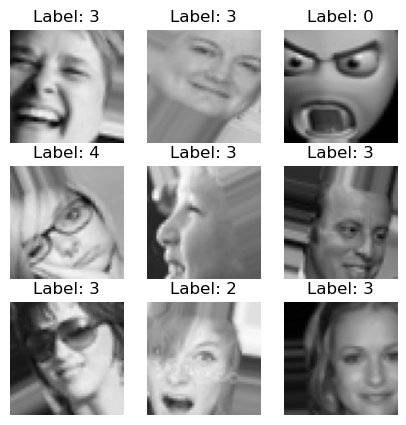

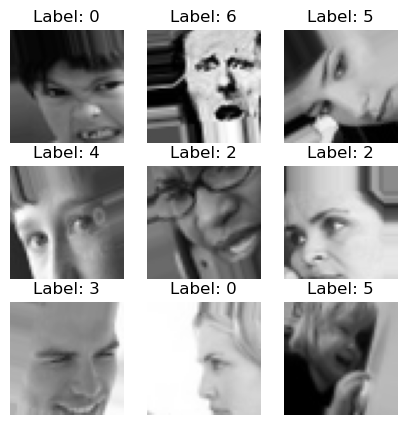

In [136]:
def display_images(generator, num_images=9):
    plt.figure(figsize=(5, 5))
    
    for i in range(num_images):
        # Fetch a batch of images
        images, labels = next(generator)
        
        # Display the first image from the batch
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0],cmap='gray')  # Convert to uint8 for display
        #plt.title(f'Label: {int(labels[0])}')
        plt.title(f'Label: {np.argmax(labels[0])}')
        plt.axis('off')
    
    plt.show()

# Display 9 sample images from the training set
display_images(train_generator, num_images=9)

# Display 9 sample images from the validation set
display_images(validation_generator, num_images=9)

## 4. Build the Model

You can use a pre-trained model like VGG16, fine-tune it for face recognition, or build a custom CNN.

Here’s an example using a pre-trained VGG16 model:

In [137]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)  # Use 'softmax' for multi-class classification

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

## 5. Train the Model

Train the model using the augmented data:

In [80]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5
901/901 [==============================] - 318s 353ms/step - loss: 1.7403 - accuracy: 0.2913 - val_loss: 1.6763 - val_accuracy: 0.3324
Epoch 2/5
901/901 [==============================] - 317s 352ms/step - loss: 1.6988 - accuracy: 0.3151 - val_loss: 1.6699 - val_accuracy: 0.3412
Epoch 3/5
901/901 [==============================] - 337s 374ms/step - loss: 1.6859 - accuracy: 0.3222 - val_loss: 1.6578 - val_accuracy: 0.3486
Epoch 4/5
901/901 [==============================] - 315s 349ms/step - loss: 1.6778 - accuracy: 0.3320 - val_loss: 1.6473 - val_accuracy: 0.3392
Epoch 5/5
901/901 [==============================] - 321s 356ms/step - loss: 1.6771 - accuracy: 0.3282 - val_loss: 1.6519 - val_accuracy: 0.3452


## 6. Confusion Matrix

In [169]:
# Predict the labels for the validation data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred,axis=1)  # For multi-class; use np.round(Y_pred) for binary classification

221/221 [==============================] - 57s 256ms/step


In [170]:
y_true = validation_generator.classes

In [171]:
y_pred 

array([2, 1, 1, ..., 1, 2, 2], dtype=int64)

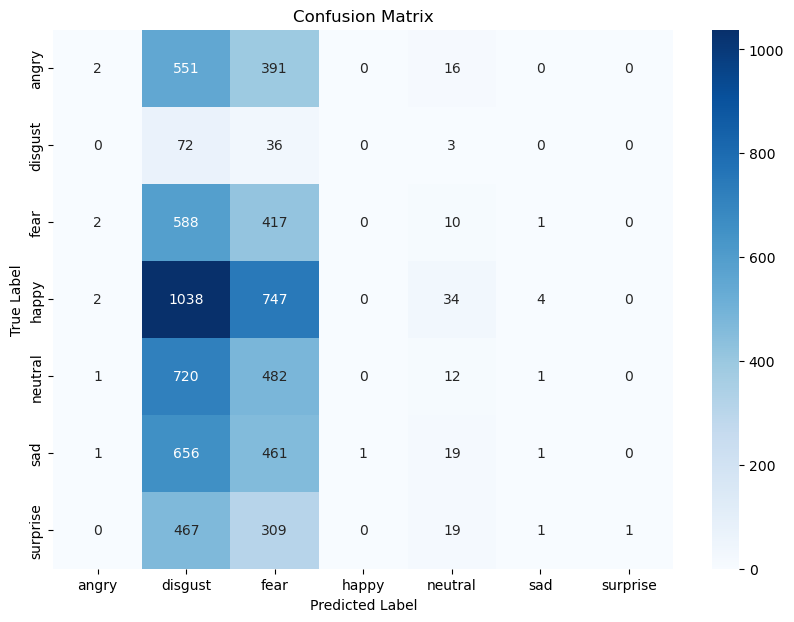

In [172]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 7. Classification Report
Generate a classification report to get precision, recall, and F1-score:

In [124]:
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

report = classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys())

# Print the classification report
print(report)

              precision    recall  f1-score   support

       angry       0.15      0.03      0.04       960
     disgust       0.00      0.00      0.00       111
        fear       0.11      0.01      0.02      1018
       happy       0.26      0.52      0.35      1825
     neutral       0.18      0.24      0.21      1216
         sad       0.17      0.11      0.13      1139
    surprise       0.12      0.11      0.11       797

    accuracy                           0.21      7066
   macro avg       0.14      0.15      0.12      7066
weighted avg       0.17      0.21      0.17      7066



## 7. Make Predictions

Use the trained model to make predictions on new images:

1/1 [==============================] - 0s 47ms/step


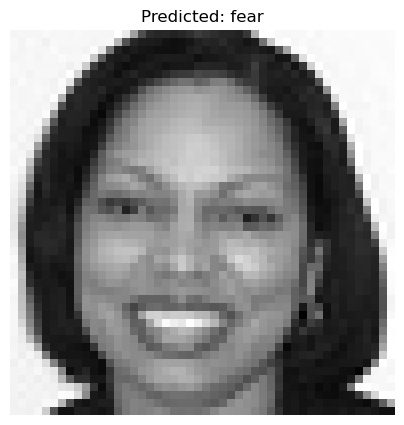

In [156]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess an image
img_path = 'C:/Users/St.Josephs/Documents/FACE EMOTION DATASET/images/validation/happy/331.jpg'
img = image.load_img(img_path, target_size=(48, 48))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

# Predict
predictions = model.predict(img_array)
# Convert the prediction to a class label
predicted_label = np.argmax(prediction)
# Get class names from the validation generator or manually define them
class_names = list(validation_generator.class_indices.keys())
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(f'Predicted: {class_names[predicted_label]}')
plt.axis('off')
plt.show()

## 8. Evaluate and Fine-Tune

After training, evaluate the model’s performance on a test set and fine-tune as needed. You can unfreeze some of the base model layers and continue training to improve accuracy.

In [ ]:
# Unfreeze some layers for fine-tuning
for layer in base_model.layers[:15]:
    layer.trainable = True

# Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

## 8. Save and Load the Model

You can save the trained model and load it later for inference:

In [ ]:
# Save the model
model.save('face_recognition_model.h5')

# Load the model
loaded_model = tf.keras.models.load_model('face_recognition_model.h5')

In [159]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path, target_size=(48, 48)):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert the image to array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match the expected input shape for the model
    img_array = np.expand_dims(img_array, axis=0)
    
    # Normalize the image (optional depending on your model training)
    img_array /= 255.0
    
    return img_array

In [160]:
# Path to your new images
new_image_paths = [
    'C:/Users/St.Josephs/Documents/FACE EMOTION DATASET/images/validation/happy/331.jpg',
    'C:/Users/St.Josephs/Documents/FACE EMOTION DATASET/images/validation/sad/359.jpg',
    'C:/Users/St.Josephs/Documents/FACE EMOTION DATASET/images/validation/surprise/413.jpg'
]

# Load and preprocess images
new_images = [load_and_preprocess_image(img_path) for img_path in new_image_paths]

# Predict the classes for the new images
predictions = [model.predict(img) for img in new_images]

# Convert predictions to class labels
predicted_labels = [np.argmax(pred) for pred in predictions]

1/1 [==============================] - 0s 31ms/step


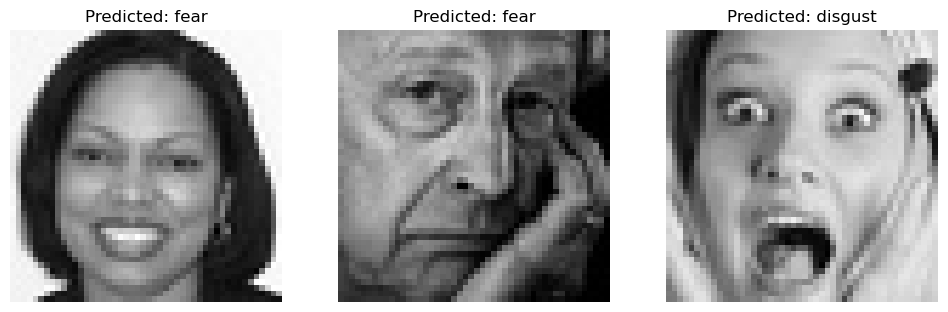

In [161]:
import matplotlib.pyplot as plt

def display_images_with_predictions(image_paths, predicted_labels, class_names):
    plt.figure(figsize=(12, 12))
    
    for i, img_path in enumerate(image_paths):
        # Load the image for display (without preprocessing)
        img = image.load_img(img_path)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f'Predicted: {class_names[predicted_labels[i]]}')
        plt.axis('off')
    
    plt.show()

# Get class names from the validation generator or manually define them
class_names = list(validation_generator.class_indices.keys())

# Display images with predictions
display_images_with_predictions(new_image_paths, predicted_labels, class_names)